In [1]:
!pwd

/Users/dmtikhonov/git_project/metrics/RecTools/examples


In [1]:
import sys
sys.path.append("/Users/dmtikhonov/git_project/metrics/RecTools")

In [2]:
from rectools.model_selection import LastNSplitter, cross_validate
from rectools.model_selection.cross_validate import _gen_2x_internal_ids_dataset
import pandas as pd
from rectools.models import PopularInCategoryModel
from rectools.dataset import Dataset
from rectools import Columns
from rectools.metrics import Intersection, Precision, Recall

/Users/dmtikhonov/git_project/metrics/RecTools/.venv/lib/python3.10/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [3]:
interactions_df = pd.DataFrame(
    [
        [10, 11, 1, 101],
        [10, 12, 1, 102],
        [10, 11, 1, 103],
        [20, 12, 1, 101],
        [20, 11, 1, 102],
        [20, 14, 1, 103],
        [30, 11, 1, 101],
        [30, 12, 1, 102],
        [40, 11, 1, 101],
        [40, 12, 1, 102],
    ],
    columns=Columns.Interactions,
)
dataset = Dataset.construct(interactions_df)

user_feature_df = pd.DataFrame(
    [
        [10, 0.5, 100],
        [30, 0.5, 300],
        [40, 0.5, 400],
        [20, 0.5, 200],
    ],
    columns=["id", "f1", "f2"],
)
item_feature_df = pd.DataFrame(
    [
        [14, "f1", "x"],
        [14, "f2", 1],
        [11, "f1", "y"],
        [11, "f2", 2],
        [12, "f1", "y"],
    ],
    columns=["id", "feature", "value"],
)
featured_dataset = Dataset.construct(
    interactions_df=interactions_df,
    user_features_df=user_feature_df,
    make_dense_user_features=True,
    item_features_df=item_feature_df,
    cat_item_features=["f1"],
)

In [5]:
splitter = LastNSplitter(n=1, n_splits=1, filter_cold_items=False, filter_already_seen=False)  # 2 splits

metrics = {
    "precision@2": Precision(2),
    "recall@1": Recall(1),
}

models= {
    # "als": ImplicitALSWrapperModel(AlternatingLeastSquares(factors=2, iterations=2, random_state=42)),
    "pop_in_cat": PopularInCategoryModel(category_feature="f1", n_categories=2)
}

actual = cross_validate(
    dataset=featured_dataset,
    splitter=splitter,
    metrics=metrics,
    models=models,
    k=2,
    filter_viewed=False,
    prefer_warm_inference_over_cold=True,
)

/Users/dmtikhonov/git_project/metrics/RecTools/rectools/models/popular_in_category.py:184: UserWarning: `n_categories` exceeds number of unique category values. Only 1 categories will be analysed
  warnings.warn(


KeyError: 2

In [6]:
dataset = featured_dataset
interactions = dataset.interactions

split_iterator = splitter.split(interactions, collect_fold_stats=True)

split_infos = []
metrics_all = []

for train_ids, test_ids, split_info in split_iterator:
    split_infos.append(split_info)

    # ### Prepare split data
    interactions_df_train = interactions.df.iloc[train_ids]  # 1x internal
    # We need to avoid fitting models on sparse matrices with all zero rows/columns =>
    # => we need to create a fold dataset which contains only hot users and items for current training
    fold_dataset = _gen_2x_internal_ids_dataset(
        interactions_df_train, dataset.user_features, dataset.item_features, True
    )
    break

In [7]:
self = PopularInCategoryModel(category_feature="f1", n_categories=2)
self._check_category_feature(fold_dataset)
interactions = self._filter_interactions(fold_dataset.interactions.df)
self._calc_category_scores(fold_dataset, interactions)
# self._define_categories_for_analysis()

In [11]:
scores_dict = {}
for column_num in [2]:
    item_idx = fold_dataset.item_features.values.getcol(column_num).nonzero()[0]  # type: ignore
    category_interactions = interactions[interactions[Columns.Item].isin(item_idx)].copy()

In [12]:
category_interactions

,user_id,item_id,weight,datetime
0,0,0,1.0,1970-01-01 00:00:00.000000101
1,0,1,1.0,1970-01-01 00:00:00.000000102
2,1,1,1.0,1970-01-01 00:00:00.000000101
3,1,0,1.0,1970-01-01 00:00:00.000000102
4,2,0,1.0,1970-01-01 00:00:00.000000101
5,3,0,1.0,1970-01-01 00:00:00.000000101


In [13]:
category_interactions.shape[0] == 0

False

In [14]:
self.category_interactions[column_num] = category_interactions
col, func = self._get_groupby_col_and_agg_func(self.popularity)
scores_dict[column_num] = self.category_interactions[column_num][col].apply(func)

In [15]:
self.category_interactions

{2:    user_id  item_id  weight                      datetime
 0        0        0     1.0 1970-01-01 00:00:00.000000101
 1        0        1     1.0 1970-01-01 00:00:00.000000102
 2        1        1     1.0 1970-01-01 00:00:00.000000101
 3        1        0     1.0 1970-01-01 00:00:00.000000102
 4        2        0     1.0 1970-01-01 00:00:00.000000101
 5        3        0     1.0 1970-01-01 00:00:00.000000101}

In [19]:
a = [1, 2, 3]
a = [x for x in a if x not in [1, 2]]

In [20]:
a

[3]

In [16]:
a = [1, 2]
for col_num in a:
    print(col_num)
    if col_num == 1:
        a.remove(col_num)

1


In [8]:
self.category_columns  # корректно

[2]

In [9]:
self.category_interactions  # некорректно

{}

In [10]:
self.category_scores  # некорректно

Series([], dtype: object)

col_num: 1  item_ids: [2]
col_num: 2 item_ids: [0, 1]  # всей айтемы во 2 категории

In [36]:
interactions

,user_id,item_id,weight,datetime
0,0,0,1.0,1970-01-01 00:00:00.000000101
1,0,1,1.0,1970-01-01 00:00:00.000000102
2,1,1,1.0,1970-01-01 00:00:00.000000101
3,1,0,1.0,1970-01-01 00:00:00.000000102
4,2,0,1.0,1970-01-01 00:00:00.000000101
5,3,0,1.0,1970-01-01 00:00:00.000000101


In [18]:
fold_dataset.interactions.df

,user_id,item_id,weight,datetime
0,0,0,1.0,1970-01-01 00:00:00.000000101
1,0,1,1.0,1970-01-01 00:00:00.000000102
2,1,1,1.0,1970-01-01 00:00:00.000000101
3,1,0,1.0,1970-01-01 00:00:00.000000102
4,2,0,1.0,1970-01-01 00:00:00.000000101
5,3,0,1.0,1970-01-01 00:00:00.000000101


In [22]:
fold_dataset.item_features.names

(('f2', '__is_direct_feature'), ('f1', 'x'), ('f1', 'y'))

In [21]:
fold_dataset.item_features.get_dense()

/Users/dmtikhonov/git_project/metrics/RecTools/rectools/dataset/features.py:424: UserWarning: Converting sparse features to dense array may cause MemoryError
  warnings.warn("Converting sparse features to dense array may cause MemoryError")


array([[2., 0., 1.],
       [0., 0., 1.],
       [1., 1., 0.]], dtype=float32)

In [1]:
import pandas as pd
import numpy as np

In [36]:
pd.options.mode.copy_on_write = True

In [37]:
a = pd.DataFrame([1, 2], columns=["one"])

In [38]:
b = a.query("one == 1")

In [39]:
b.loc["two"] = 2

In [31]:
b

,one,two
0,1,2


In [5]:
a.all()

False

In [6]:
a.none()

AttributeError: 'Series' object has no attribute 'none'

In [4]:
a.any()

True

In [2]:
merged = pd.DataFrame(
    {
        "user": [1, 1, 2, 2, 3, 3],
        "rank": [np.nan, 1, np.nan, np.nan, 2, 3]
    }
)

In [18]:
merged["isna"] = merged["rank"].isna()

In [19]:
res = merged.groupby("user")["isna"].all().astype("int")

In [20]:
del merged["isna"]

In [21]:
res

user
1    0
2    1
3    0
Name: isna, dtype: int64

In [15]:
merged

,user,rank
0,1,NaN
1,1,1.0
2,2,NaN
3,2,NaN
4,3,2.0
5,3,3.0


In [7]:
merged.dropna(subset=["rank"])["user"].nunique()

2

In [8]:
merged["user"].nunique()

3

In [5]:
stats = merged.groupby("user")["rank"].isna().any()

AttributeError: 'SeriesGroupBy' object has no attribute 'isna'

In [1]:
from typing import Literal

def accepts_only_four(x: Literal[4]) -> None:
    pass

accepts_only_four(4)   # OK
accepts_only_four(19)  # Rejected


In [2]:
accepts_only_four(19) 

In [3]:
PrimaryColors = Literal["red", "blue", "yellow"]
SecondaryColors = Literal["purple", "green", "orange"]
AllowedColors = Literal[PrimaryColors, SecondaryColors]

def paint(color: AllowedColors) -> None:
    return

paint("red")        # Type checks!
paint("turquoise")  # Does not type check

In [16]:
import attr
from attrs import define, field

@attr.s(auto_attribs=True)
class MetricAtK:
    """
    Base class of metrics that depends on `k` -
    a number of top recommendations used to calculate a metric.

    Warning: This class should not be used directly.
    Use derived classes instead.

    Parameters
    ----------
    k : int
        Number of items at the top of recommendations list that will be used to calculate metric.
    """

    k: int
    
@define  
class _AUCMetric(MetricAtK):
    insufficient_handling: str = field()
    @insufficient_handling.validator
    def _check_insufficient_handling(self, attribute, value) -> None:
        if value != "true":
            raise ValueError("wrong")

In [1]:
import pandas as pd

In [53]:
df = pd.DataFrame(
    {
        "user": [3, 1, 1, 2],
        "v": [0, 10, 20, 30]
    }
)
df

,user,v
0,3,0
1,1,10
2,1,20
3,2,30


In [58]:
grouped = df.groupby("user", sort=False)
stats = grouped.agg(a=("v", "sum"), b=("v", "cumsum"))
stats

,a,b
0,NaN,0
1,30.0,10
2,30.0,30
3,0.0,30


In [57]:
cumsumstats = grouped.agg(b=("v", "cumsum"))

In [55]:
pd.concat([df, stats], axis=1)

,user,v,b
0,3,0,NaN
1,1,10,30.0
2,1,20,30.0
3,2,30,0.0


In [10]:
n_fp_insufficient = pd.Series([])

In [11]:
n_fp_insufficient[n_fp_insufficient < 5].index.values

array([], dtype=int64)

In [13]:
a = pd.Series([1, 2, 3], index = [1, 2, 3])

In [14]:
b = pd.Series([4, 5, 6, 7], index = [1, 2, 3, 4])

In [26]:
a.rename("a").to_frame().join(b.rename("b"), how="inner")

,a,b
1,1,4
2,2,5
3,3,6


In [18]:
a.reset_index().merge(b.reset_index(), on="index", how="inner")

,index,0_x,0_y
0,1,1,4
1,2,2,5
2,3,3,6


In [12]:
a.reset

'Series'

In [8]:
sum([True, False, False])

1

In [11]:
a.insufficient_handling

'example'

In [4]:
from catboost import CatBoostClassifier, Pool

train_data = [[1, 3],
              [0, 4],
              [1, 7]]
train_labels = [1, 0, 1]

# catboost_pool = Pool(train_data, train_labels)

model = CatBoostClassifier(learning_rate=0.001)
model.fit(train_data,
          train_labels,
          verbose=False)

model.save_model("model")

from_file = CatBoostClassifier()

from_file.load_model("model")

In [5]:
model.get_params()

{'learning_rate': 0.001}

In [6]:
from_file.get_params()

{'learning_rate': 0.001, 'loss_function': 'Logloss', 'verbose': 0}

In [10]:
two = CatBoostClassifier(learning_rate=0.1).load_model("model")

In [11]:
two.get_params()

{'learning_rate': 0.001, 'loss_function': 'Logloss', 'verbose': 0}

In [17]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit([[0, 0], [1, 1], [2, 2]], [0, 1, 2])

LinearRegression()

In [ ]:
# sklearn get params
def get_params(self, deep=True):
    """
    Get parameters for this estimator.

    Parameters
    ----------
    deep : bool, default=True
        If True, will return the parameters for this estimator and
        contained subobjects that are estimators.

    Returns
    -------
    params : dict
        Parameter names mapped to their values.
    """
    out = dict()
    for key in self._get_param_names():
        value = getattr(self, key)
        if deep and hasattr(value, "get_params") and not isinstance(value, type):
            deep_items = value.get_params().items()
            out.update((key + "__" + k, val) for k, val in deep_items)
        out[key] = value
    return out

In [20]:
from sklearn.linear_model import SGDClassifier
X = [[0., 0.], [1., 1.]]
y = [0, 1]
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
clf.fit(X, y)

/Users/dmtikhonov/git_project/libs/RecTools/.venv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(max_iter=5)

In [21]:
clf.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 5,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [18]:
reg.get_params(deep=True)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [19]:
reg.get_params(deep=False)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [1]:
import sys
sys.path.append("/Users/dmtikhonov/git_project/metrics/RecTools")

In [4]:
import pandas as pd
import numpy as np

In [12]:
n_rows = 10000
prepared_interactions = pd.DataFrame(
    {
        "user": np.random.randint(1, 100, n_rows),
    }
)
reco = pd.DataFrame(
    {
        "user": np.random.randint(1, 100, n_rows),
    }
)

In [15]:
%%time
test_users = prepared_interactions["user"].drop_duplicates()
prepared_reco = reco.merge(test_users, on="user", how="inner")

CPU times: user 4.11 ms, sys: 2.14 ms, total: 6.25 ms
Wall time: 4.41 ms


In [16]:
%%time
test_users = prepared_interactions["user"].unique()
prepared_reco = reco[reco["user"].isin(test_users)]

CPU times: user 1.23 ms, sys: 648 µs, total: 1.87 ms
Wall time: 1.65 ms


In [14]:
import pandas as pd
import numpy as np
# import seaborn as sns
import numpy as np

In [40]:
df

,user,inter,money
0,1,1,100
1,1,0,1
2,1,0,50
3,2,1,1000
4,2,1,500
5,2,0,0


In [15]:
df = pd.DataFrame({
    "user": np.random.randint(1, 10, 100),
    "inter":  np.random.randint(1, 10, 100),
})

In [17]:
prepared_interactions = df.drop_duplicates(["user", "inter"]).reindex(["user", "inter"])
prepared_interactions.loc[:, "__test_positive"] = True

In [32]:
df.groupby("user")["inter"].count()

user
1    3
2    3
Name: inter, dtype: int64

In [30]:
stats = (
    df
    .groupby('user')
    .agg(
        max_inter=('inter', 'cumsum'), 
        mean_money=('money', 'mean'), 
        )
)

In [36]:
a = stats["mean_money"].dropna()
a

1     50.333333
2    500.000000
Name: mean_money, dtype: float64

In [39]:
a.rename_axis("iser")

iser
1     50.333333
2    500.000000
Name: mean_money, dtype: float64

In [3]:
import matplotlib.pyplot as plt

In [4]:
from rectools import Columns
from rectools.metrics import Precision, Recall, MAP, NDCG, PAUC, calc_metrics, PAP
from rectools.metrics.base import outer_merge_reco

In [22]:
reco = pd.DataFrame(
    {
        Columns.User: [1, 1, 2, 3, 5],
        Columns.Item: [1, 2, 1, 1, 1],
        Columns.Rank: [1, 2, 1, 1, 2],
    }
)
ref_reco = reco
# interactions = pd.DataFrame(
#     {
#         Columns.User: [1, 1, 2, 4, 5],
#         Columns.Item: [1, 2, 2, 1, 1],
#     }
# )
# PAUC(k=1).calc(reco, interactions)

In [23]:
%%time
ref_reco is reco

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


True

In [5]:
class MetricsChecker:
    def __init__(
        self,
        n_users = 4, 
        k_recs = 3,
        users_tp_ranks = {},
        users_num_fn = [1, 1, 1, 1],
    ):
        self.n_users = n_users
        self.k_recs = k_recs
        self.users_tp_ranks = users_tp_ranks
        self.users_num_fn = users_num_fn
        
        self.reco, self.interactions = self.generate_reco_and_interactions(n_users, k_recs, users_tp_ranks, users_num_fn)
        self.full_merged_reco = outer_merge_reco(self.reco, self.interactions)
        
        self.metrics = {
            f"map_{k_recs}_by_all": MAP(k_recs),
            f"map_{k_recs}_by_k": MAP(k_recs, divide_by_k=True),
            f"ndcg_{k_recs}": NDCG(k_recs),
            f"pap_{k_recs}": PAP(k_recs, insufficient_cases="don't check"),
            f"pauc_{k_recs}": PAUC(k_recs, insufficient_cases="don't check")
        }
        self.res = self.get_metrics_df(self.metrics, self.reco, self.interactions)
        
    @classmethod
    def get_metrics_df(cls, metrics, reco, interactions):
        res = pd.DataFrame()
        for metric_name, metric in metrics.items():
            res[metric_name] = metric.calc_per_user(reco, interactions)
        return res.round(2)   

    @classmethod
    def generate_reco_and_interactions(
        cls, n_users, k_recs, users_tp_ranks, users_num_fn
    ):
        reco = pd.DataFrame(
        {
            Columns.User: np.repeat(np.arange(1, n_users+1), k_recs),
            Columns.Item: np.tile(np.arange(1, k_recs+1), n_users),
            Columns.Rank: np.tile(np.arange(1, k_recs+1), n_users),
        }
        )
        inters = []
        for user_id, tp_ranks in users_tp_ranks.items():
            inters.append(pd.DataFrame(
                {
                    Columns.User: [user_id] * len(tp_ranks),
                    Columns.Item: tp_ranks
                }
            ))
        for i, num_fn in enumerate(users_num_fn):
            inters.append(pd.DataFrame(
                {
                    Columns.User: [i+1] * num_fn,
                    Columns.Item: [100+k for k in range(num_fn)]
                }
            ))  
        interactions = pd.concat(inters, axis=0)
        return reco, interactions  
    def visualize_situation(self, ax = None, s=500):
        full_merged_df = self.full_merged_reco
        start_dummy_rank = full_merged_df["rank"].max() + 2
        full_merged_df["dummy_rank"] = full_merged_df["rank"]
        full_merged_df.loc[full_merged_df["rank"].isna(), "dummy_rank"] = full_merged_df.loc[full_merged_df["rank"].isna()].groupby("user_id").cumcount() + start_dummy_rank

        with sns.axes_style("whitegrid"):
            palette ={True: "orange", False: "white"}
            ranked = ~full_merged_df["rank"].isna()
            ax = sns.scatterplot(data=full_merged_df, x="user_id", y="dummy_rank", hue="__test_positive", s=s, palette=palette, ec="black", ax = ax)
            users = range(1, full_merged_df["user_id"].nunique() + 1)
            ranks = range(0, int(full_merged_df["dummy_rank"].max()) + 1)
            max_rank = full_merged_df[ranked]["rank"].max()
            min_nan_rank = full_merged_df[~ranked]["dummy_rank"].min()
            ax.set_xticks(users)
            ax.set_yticks(ranks)
            ax.set_yticklabels([rank if rank <= max_rank and rank > 0 else "" if rank == 0 or rank != min_nan_rank else "none" for rank in ranks])
            ax.axhline(color='white')
            ax.get_legend().remove()
            ax.set_xlim((0, full_merged_df["user_id"].nunique()+1))
            ax.set_ylim((0, full_merged_df["dummy_rank"].max() + 1))
            ax.invert_yaxis()
            ax.set(xlabel='user', ylabel='rank')
            ax.grid(False) 
    def visualize_metrics(self, add_avg=False, ax = None, users_legend=False, metrics=None):
        with sns.axes_style("whitegrid"):
            look = self.res.reset_index(names="user_id")
            if metrics is not None:
                look = look.reindex(metrics+["user_id"], axis=1)
            trying = look.melt(id_vars="user_id")
            if add_avg:
                avg = pd.DataFrame(trying.groupby("variable")["value"].mean())
                avg["user_id"] = "avg"
                trying = pd.concat([trying, avg.reset_index()], axis=0)
            
            ax = sns.barplot(data = trying, x="variable", y="value", hue="user_id", palette="viridis", ax = ax, legend=users_legend)
            ax.set_ylim((0, 1))
    def visualize_all(self, add_avg=False, s=500, users_legend=False, metrics = None):
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        self.visualize_situation(ax=axes[0], s=s)
        self.visualize_metrics(add_avg=add_avg, ax=axes[1], metrics=metrics)
    # def generate_clones(self, user_clones):
    #     for user_id, num_clones in user_clones.items():
    #         user_reco = self.reco[self.reco["user_id"]==user_id]
    #         user_inter = self.interactions[self.interactions["user_id"]==user_id]
    #         new_ids = [f"clone_{user_id}_n_{num_clone}" for num_clone in range(1, num_clones+1)]
            
            

## Кейс 1: Единственный оправдавший ожидания
Чем больше таргетов модель подтягивает, тем лучше метрики, рост постепенный, все метрики ведут себя идентично

In [ ]:
METRICS = ["map_10_by_all", "map_10_by_k", "ndcg_10", "pauc_10"]

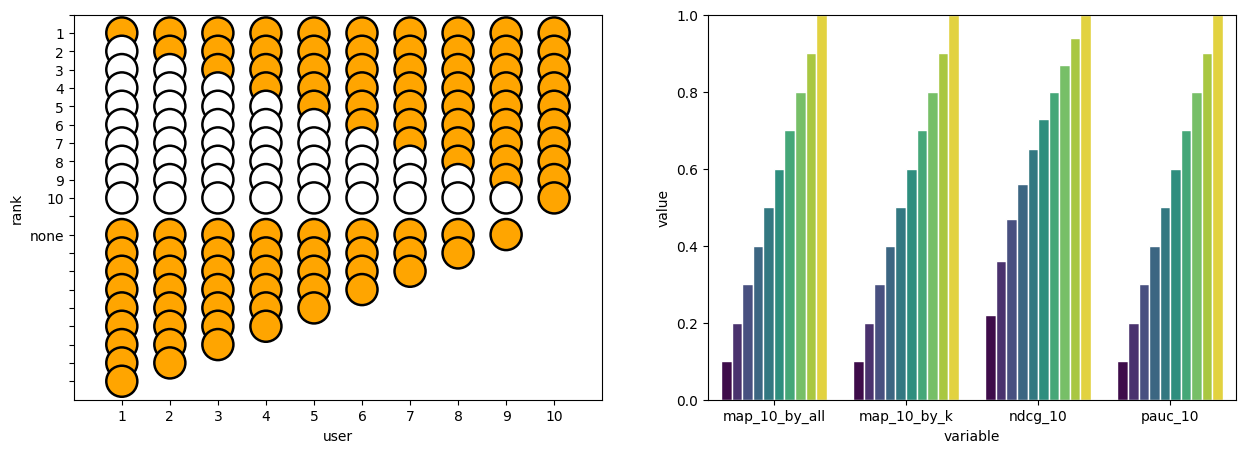

In [ ]:
example = {
    "n_users": 10, 
    "k_recs": 10,
    "users_tp_ranks": {k: list(range(1, k+1)) for k in range(1, 11)},
    "users_num_fn": list(range(9, -1, -1))
}
test = MetricsChecker(**example)
test.visualize_all(s=500, metrics=METRICS)

## Кейс 2: реакция на ранг единственного таргета
- MAP делает сильный перевес на 1 ранг
- NDCG следует
- pAUC ведёт себя равномерно
- MAP_by_k и NDCG имеют недостижимую единицу

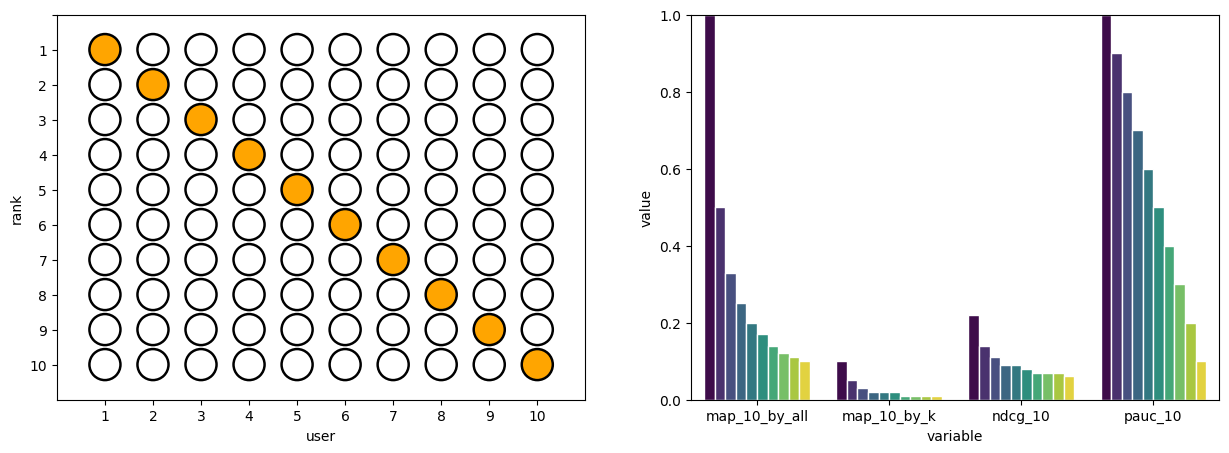

In [ ]:
example = {
    "n_users": 10, 
    "k_recs": 10,
    "users_tp_ranks": {k: [k] for k in range(1, 11)},
    "users_num_fn": [0] * 10
}
test = MetricsChecker(**example)
test.visualize_all(s=500, metrics=METRICS)

## Кейс 3: влияние количества False-Negative
- MAP_by_k и NDCG не парятся о том, сколько таргетов осталось вне списка рекомендаций
- MAP_by_all и PAUC ведут себя адекватно и идентично

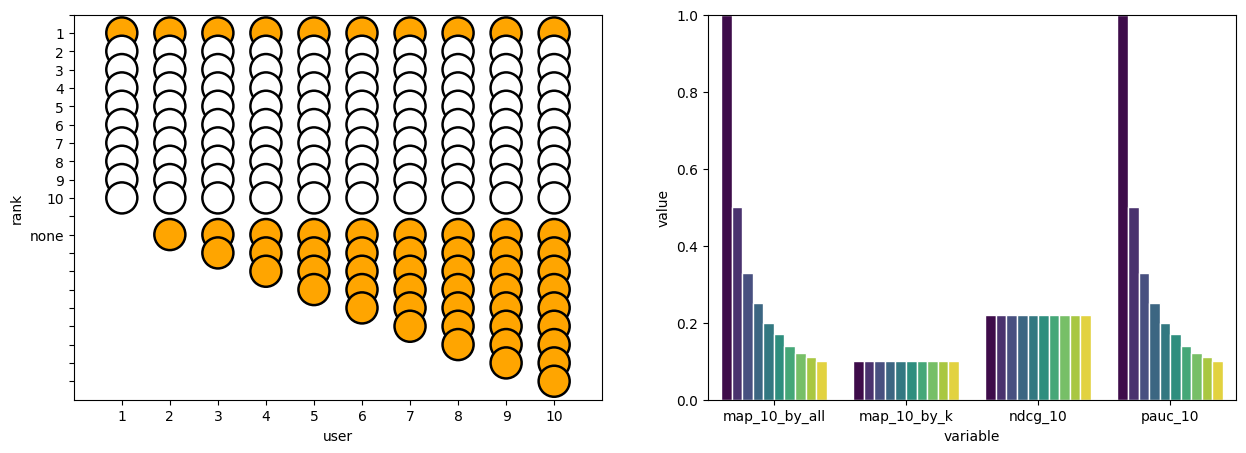

In [ ]:
example = {
    "n_users": 10, 
    "k_recs": 10,
    "users_tp_ranks": {k: [1] for k in range(1, 11)},
    "users_num_fn": list(range(0, 10))
}
test = MetricsChecker(**example)
test.visualize_all(s=500, metrics=METRICS)

## Кейс 4: растим одновременно False-Negative и True-Positive
- MAP_by_k и NDCG растут
- MAP_by_all и PAUC считают все кейсы равноценными

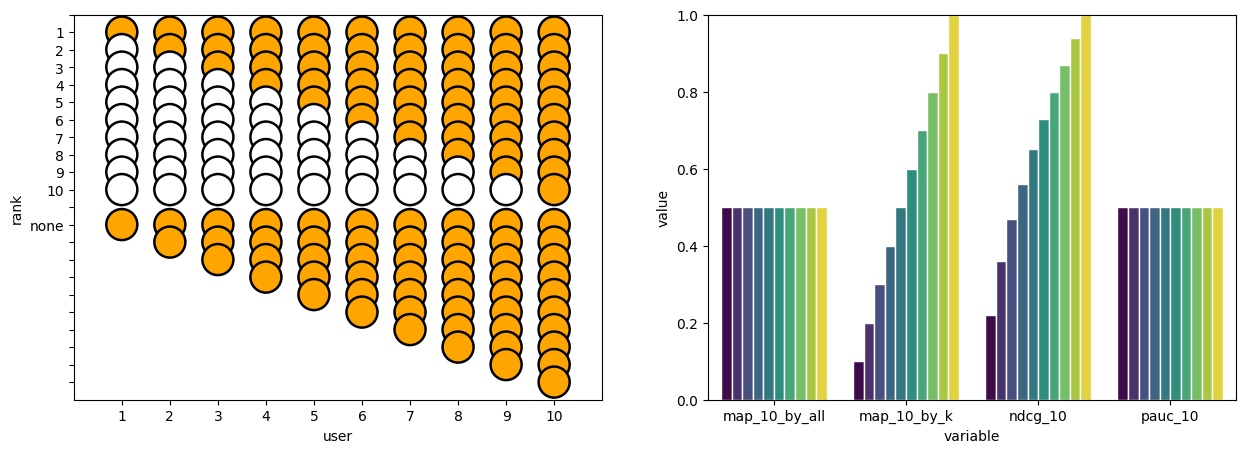

In [ ]:
example = {
    "n_users": 10, 
    "k_recs": 10,
    "users_tp_ranks": {k: list(range(1, k+1)) for k in range(1, 11)},
    "users_num_fn": list(range(1, 11))
}
test = MetricsChecker(**example)
test.visualize_all(s=500, metrics=METRICS)

## Кейс 5: идеальный алгоритм с разным количеством таргетов
- MAP_by_k и NDCG показывают рост при количестве таргетов (а единица недостижима)
- MAP_by_all и PAUC считают все кейсы равноценными со скором единицей (идеал достигнут!)

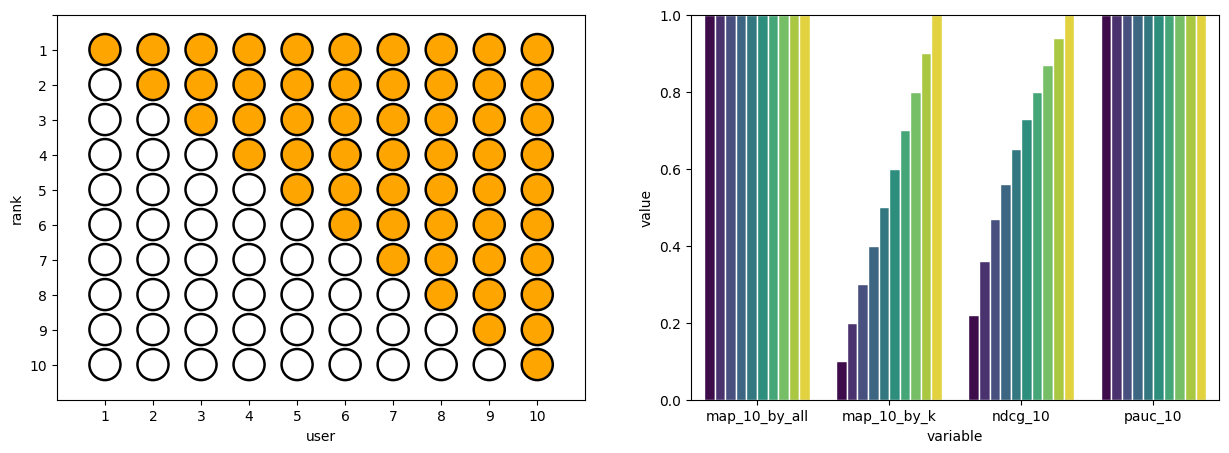

In [ ]:
example = {
    "n_users": 10, 
    "k_recs": 10,
    "users_tp_ranks": {k: list(range(1, k+1)) for k in range(1, 11)},
    "users_num_fn": [0]*10
}
test = MetricsChecker(**example)
test.visualize_all(s=500, metrics=METRICS)

## Кейс 6: кого штрафуем, а кого поощряем (смотрим MAP_by_all и pAUC)
- MAP считает равнозначными юзеров 2 и 3. Оба кейса - половина от идеала (1 юзер)
- pAUC считает 3 кейс (таргет на 2 ранге) близким к первому (таргет на 1 ранге), а ситуацию 2 кейса считает за половину от идеала. И дальше только 7 юзер будет иметь такое же значение pAUC как 2.
- MAP накидывает юзерам, для которых рекомендации попали на 1 ранг, даже если у них есть false negative
- pAUC штрафует за false negative

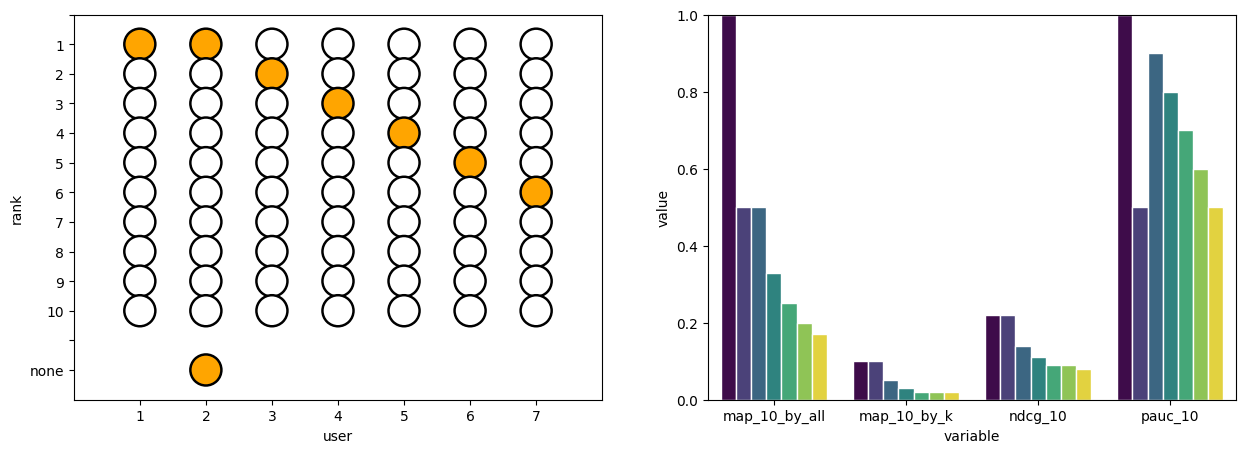

In [ ]:
example = {
    "n_users": 7, 
    "k_recs": 10,
    "users_tp_ranks": {1: [1], 2:[1], 3:[2], 4: [3], 5: [4], 6: [5], 7: [6]},
    "users_num_fn": [0, 1, 0, 0, 0, 0, 0]
}
test = MetricsChecker(**example)
test.visualize_all(s=500, metrics=METRICS)

## Кейс 7: зачем нам pAp?
- pAp имеет все бонусы pAUC
- pAp делает достижимой единицу для кейсов с излишним количеством таргетов на тесте (больше k)
- pAp по интерпретации максимально приближается к запросу "Насколько хорошо рекомендации отранжированы по шкале от 0 до 1?"

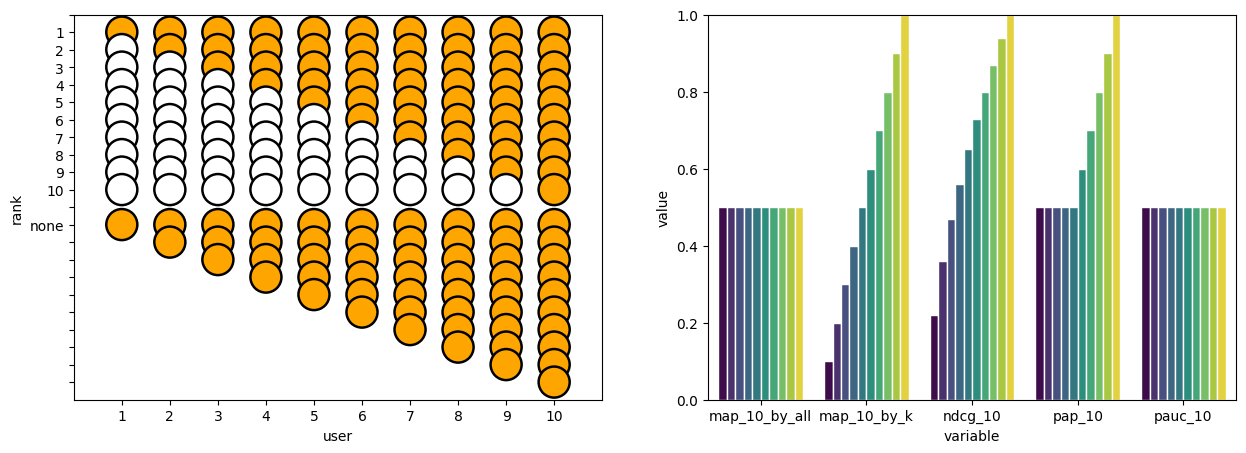

In [ ]:
example = {
    "n_users": 10, 
    "k_recs": 10,
    "users_tp_ranks": {k: list(range(1, k+1)) for k in range(1, 11)},
    "users_num_fn": list(range(1, 11))
}
test = MetricsChecker(**example)
test.visualize_all(s=500)

# AB test TL

In [8]:
import pandas as pd
from rectools import Columns
from rectools.dataset import Dataset
from rectools.model_selection import TimeRangeSplitter, cross_validate
from rectools.models import PopularModel, ImplicitItemKNNWrapperModel, EASEModel
from implicit.nearest_neighbours import BM25Recommender, TFIDFRecommender, CosineRecommender
from datetime import timedelta

/Users/dmtikhonov/git_project/metrics/RecTools/.venv/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [9]:
interactions = pd.read_csv("data/interactions.csv")

In [10]:
interactions.head()

,user_id,item_id,datetime,weight
0,22294,1854831,2019-02-02,1
1,23447,3684055,2019-01-11,1
2,24639,1856365,2020-12-08,1
3,24786,4247990,2020-12-19,1
4,24786,4293982,2021-05-30,1


In [11]:
splitter = TimeRangeSplitter("7D")

In [12]:
models = {
    "popular_14": PopularModel(period=timedelta(days=14)),
    "tfidf_k_20": ImplicitItemKNNWrapperModel(TFIDFRecommender(20)),
    "bm25_k_20_k1_005_b_01": ImplicitItemKNNWrapperModel(BM25Recommender(20, 0.05, 0.1)),
    "ease": EASEModel()
    # "slim"
}

In [13]:
metrics = {}
for k_recs in [3, 6, 12]:
    metrics.update({
    f"map_{k_recs}_by_all": MAP(k_recs),
    f"map_{k_recs}_by_k": MAP(k_recs, divide_by_k=True),
    f"ndcg_{k_recs}": NDCG(k_recs),
    f"pap_{k_recs}": PAP(k_recs, insufficient_cases="don't check"),
    f"pauc_{k_recs}": PAUC(k_recs, insufficient_cases="don't check")
})

In [14]:
dataset = Dataset.construct(interactions)

In [15]:
# cv_results = cross_validate(
#     dataset=dataset,
#     splitter=splitter,
#     models=models,
#     metrics=metrics,
#     k=12,
#     filter_viewed=True,
# )

In [16]:
pd.DataFrame(cv_results["metrics"])

NameError: name 'cv_results' is not defined

In [19]:
splits = [k for k in splitter.split(dataset.interactions)]

In [20]:
train_ids = splits[0][0]
test_ids = splits[0][1]

In [21]:
test_interactions = dataset.interactions.df.iloc[test_ids]

In [22]:
test_users = test_interactions["user_id"].unique()

In [23]:
train_interactions = dataset.interactions.df.iloc[train_ids]

In [24]:
train = Dataset.construct(train_interactions)

In [25]:
def make_downsample(interactions: pd.DataFrame, iqr_coef = 1.5, random_state=32) -> pd.DataFrame:
        """
        Downsample the size of interactions, excluding some interactions with popular items.
        Algorithm:
            1. Calculate item popularity distribution from interactions;
            2. Find first (Q1) and third (Q3) quartiles in items popularity distribution;
            3. Calculate IQR = Q3 - Q1;
            4. Calculate maximum value inside by formula: Q3 + iqr_coef * IQR;
            5. Down-sample for all exceeding items in interactions,
            randomly keeping the maximum group of users to a size not exceeding
            maximum value inside
        Parameters
        ----------
        interactions : pd.DataFrame
            Table with previous user-item interactions,
            with columns `Columns.User`, `Columns.Item`.
        iqr_coef : float, default 1.5
            Coefficient for defining as the maximum value inside the border.
        random_state: float, default 32
            Pseudorandom number generator state to control the down-sampling.
        Returns
        -------
        pd.DataFrame
            downsampling interactions.
        """
        if len(interactions) == 0:
            return interactions

        item_popularity = interactions[Columns.Item].value_counts()

        quantiles = item_popularity.quantile(q=[0.25, 0.75])
        q1, q3 = quantiles.loc[0.25], quantiles.loc[0.75]
        iqr = q3 - q1
        max_border = int(q3 + iqr_coef * iqr)

        item_outside_max_border = item_popularity[item_popularity > max_border].index

        interactions_result = interactions[~interactions[Columns.Item].isin(item_outside_max_border)]
        interactions_downsampling = interactions[interactions[Columns.Item].isin(item_outside_max_border)]

        interactions_downsampling = (
            interactions_downsampling.groupby(Columns.Item, as_index=False)[Columns.User]
            .agg(lambda users: users.sample(max_border, random_state=random_state).tolist())
            .explode(Columns.User)
        )

        interactions_result = pd.concat([interactions_result, interactions_downsampling]).sort_values(
            Columns.User, ignore_index=True
        )

        interactions_result[Columns.User] = interactions_result[Columns.User].astype(interactions[Columns.User].dtypes)
        interactions_result[Columns.Item] = interactions_result[Columns.Item].astype(interactions[Columns.Item].dtypes)

        if Columns.Rank in interactions.columns:
            interactions_result = pd.merge(
                interactions_result[Columns.UserItem],
                interactions,
                how="left",
                on=Columns.UserItem,
            )
            interactions_result[Columns.Rank] = interactions_result[Columns.Rank].astype(
                interactions[Columns.Rank].dtypes
            )

        return interactions_result

In [26]:
donwsampled_test = make_downsample(test_interactions, iqr_coef=0.5)

In [27]:
downs_test_users = donwsampled_test["user_id"].unique()

In [28]:
 metrics_all = []
 for model_name, model in models.items():
        model.fit(train)
        # reco = model.recommend(  # 1x internal
        #     users=downs_test_users,
        #     dataset=train,
        #     k=24,
        #     filter_viewed=True,
        # )
        # metric_values = calc_metrics(
        #     metrics,
        #     reco=reco,
        #     interactions=donwsampled_test,
        #     prev_interactions=train_interactions,
        #     catalog=train_interactions["item_id"].unique(),
        # )
        # res = {"model": model_name}
        # res.update(metric_values)
        # metrics_all.append(res)

In [ ]:
pd.DataFrame(metrics_all)

""
